<a href="https://colab.research.google.com/github/ljin8/Assignment3/blob/main/AML_Assignment_3_Lei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Assignment 3 - RRN - Weather Time Series Forecasting**

# **Name: Lei Jin**

# **Date: 04-01-2025**

**A temperature-forecasting example- Data Upload from mazon Web Services (AWS) /keras**

In [ ]:
!pip install --upgrade tensorflow==2.12

In [ ]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-03-27 13:37:17--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 16.15.177.101, 52.217.201.184, 52.216.10.125, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|16.15.177.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  22.9MB/s    in 0.6s    

2025-03-27 13:37:17 (22.9 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features**

In [ ]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


**Parsing the data- converting the comma-separated values into floating-point numbers, and then storing specific values in the temperature and raw_data arrays for further processing or analysis.**

In [ ]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

Text(0, 0.5, 'Temperature')

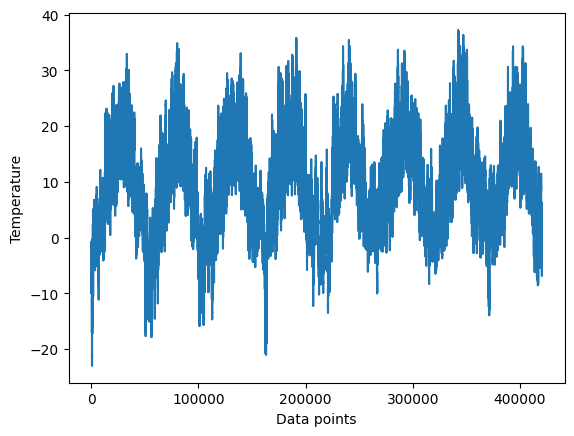

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Plotting the first 10 days of the temperature timeseries- As given that one day data has 144 data points hence 10days will have 1440 data points**

Text(0, 0.5, 'Temperature')

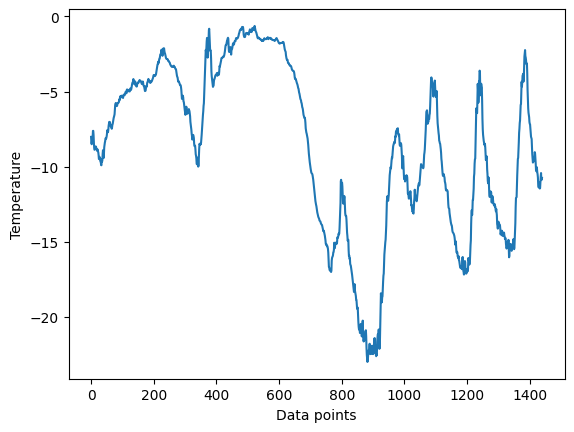

In [ ]:
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

**Computing the number of samples we'll use for each data split- 50% for Train, 25%- validation**

In [ ]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### **Preparing the data**

**Normalizing the data- Since the data is already in a numerical format, vectorization is unnecessary. However, given that the data scales differ across variables, with temperature ranging from -20 to +30 and pressure measured in millibars, it is advisable to standardize all variables.**

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [ ]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing - it is required because the samples in the dataset are highly redundant Hence, it would be inefficient to allocate memory for each sample explicitly. Instead, we will generate the samples dynamically.**

In [ ]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [ ]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### **Model 1 - A Common-Sense, Non-Machine-Learning Baseline**

**Computing the common-sense baseline MAE - This defined function "evaluate_naive_method" provides a baseline for evaluating the performance of a simple forecasting approach, where the last value in the input sequence is used as a prediction for the next value.**

In [ ]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


Common-sense baseline approach is to predict that the temperature 24 hours ahead will be identical to the current temperature. By using this straightforward baseline, the validation MAE (Mean Absolute Error) is 2.44 degrees Celsius, while the test MAE is 2.62 degrees Celsius. In other words, assuming that the temperature in the future remains the same as the current temperature would result in an average deviation of approximately two and a half degrees.

### **Model 2 - A Basic Machine-Learning Model - Dense Layer**

**Training and evaluating a densely connected model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model_2 = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

model_2.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history_2 = model_2.fit(train_dataset, epochs=10,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 53s 64ms/step - loss: 13.1750 - mae: 2.8057 - val_loss: 12.3768 - val_mae: 2.7654
Epoch 2/10
819/819 [==============================] - 49s 59ms/step - loss: 9.1724 - mae: 2.3829 - val_loss: 11.3465 - val_mae: 2.6494
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 8.3448 - mae: 2.2768 - val_loss: 10.3999 - val_mae: 2.5227
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 7.8822 - mae: 2.2136 - val_loss: 14.5090 - val_mae: 3.0360
Epoch 5/10
819/819 [==============================] - 52s 64ms/step - loss: 7.5596 - mae: 2.1704 - val_loss: 11.8006 - val_mae: 2.6955
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 7.2989 - mae: 2.1331 - val_loss: 11.9366 - val_mae: 2.7159
Epoch 7/10
819/819 [==============================] - 48s 59ms/step - loss: 7.1160 - mae: 2.1027 - val_loss: 13.5926 - val_mae: 2.9017
Epoch 8/10
819/819 [==============================] - 

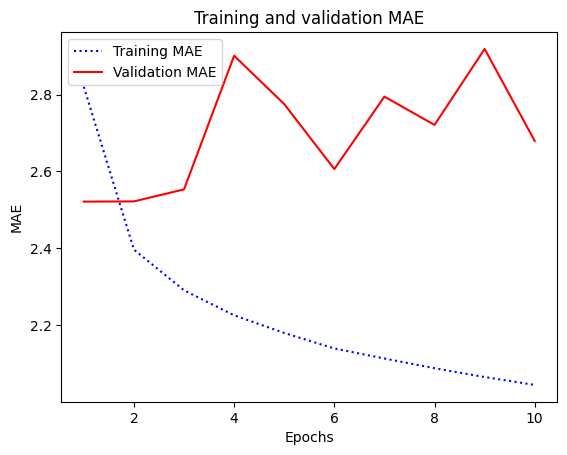

In [ ]:
import matplotlib.pyplot as plt
loss = history_2.history["mae"]
val_loss = history_2.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_2 = keras.models.load_model("jena_dense.keras")
print(f"✅ Validation MAE: {model_2.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_2.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 17s 40ms/step - loss: 10.2690 - mae: 2.5219
✅ Validation MAE: 2.52
405/405 [==============================] - 17s 40ms/step - loss: 11.5818 - mae: 2.6704
✅ Test MAE: 2.67


## **Model 3 - A Simple RNN**

In [ ]:
model_3 = keras.Sequential([
    layers.SimpleRNN(32, return_sequences=False),
    layers.Dense(1)
])

model_3.compile(
    optimizer='rmsprop',
    loss='mse',
    metrics=['mae']
)

callbacks = [
    keras.callbacks.ModelCheckpoint("simple_rnn.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history_3 = model_3.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30
819/819 [==============================] - 79s 95ms/step - loss: 25.4392 - mae: 3.6048 - val_loss: 9.2914 - val_mae: 2.3595
Epoch 2/30
819/819 [==============================] - 79s 96ms/step - loss: 10.3149 - mae: 2.5040 - val_loss: 8.9970 - val_mae: 2.3293
Epoch 3/30
819/819 [==============================] - 77s 93ms/step - loss: 10.0203 - mae: 2.4642 - val_loss: 9.0571 - val_mae: 2.3414
Epoch 4/30
819/819 [==============================] - 78s 94ms/step - loss: 9.7995 - mae: 2.4355 - val_loss: 8.8513 - val_mae: 2.3177
Epoch 5/30
819/819 [==============================] - 77s 93ms/step - loss: 9.5835 - mae: 2.4059 - val_loss: 9.1120 - val_mae: 2.3579
Epoch 6/30
819/819 [==============================] - 78s 94ms/step - loss: 9.3920 - mae: 2.3805 - val_loss: 9.0841 - val_mae: 2.3440
Epoch 7/30
819/819 [==============================] - 77s 94ms/step - loss: 9.2451 - mae: 2.3621 - val_loss: 9.0940 - val_mae: 2.3446
Epoch 8/30
819/819 [==============================] - 78s 9

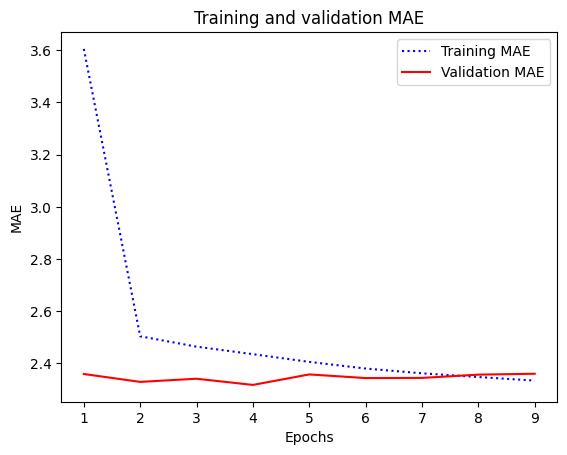

In [ ]:
import matplotlib.pyplot as plt
loss = history_3.history["mae"]
val_loss = history_3.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_3 = keras.models.load_model("simple_rnn.keras")
print(f"✅ Validation MAE: {model_3.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_3.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 20s 48ms/step - loss: 8.8513 - mae: 2.3177
✅ Validation MAE: 2.32
405/405 [==============================] - 21s 51ms/step - loss: 9.9804 - mae: 2.4484
✅ Test MAE: 2.45


### **Model 4 - 1D convolutional model**

In [ ]:
model_4 = keras.Sequential([
    layers.Conv1D(32, 5, activation="relu", input_shape=(None, raw_data.shape[-1])),
    layers.MaxPooling1D(3),
    layers.Conv1D(32, 5, activation="relu"),
    layers.GRU(32),
    layers.Dense(1)
])

model_4.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv1d_rnn.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

history_4 = model_4.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)


Epoch 1/30
819/819 [==============================] - 111s 130ms/step - loss: 18.8904 - mae: 3.2171 - val_loss: 10.9386 - val_mae: 2.5706
Epoch 2/30
819/819 [==============================] - 107s 130ms/step - loss: 9.2046 - mae: 2.3807 - val_loss: 11.5118 - val_mae: 2.6864
Epoch 3/30
819/819 [==============================] - 110s 134ms/step - loss: 7.5016 - mae: 2.1427 - val_loss: 12.6402 - val_mae: 2.7708
Epoch 4/30
819/819 [==============================] - 124s 151ms/step - loss: 6.1289 - mae: 1.9285 - val_loss: 14.3705 - val_mae: 2.9648
Epoch 5/30
819/819 [==============================] - 127s 155ms/step - loss: 5.0948 - mae: 1.7501 - val_loss: 14.7290 - val_mae: 3.0094
Epoch 6/30
819/819 [==============================] - 108s 131ms/step - loss: 4.3704 - mae: 1.6143 - val_loss: 14.6941 - val_mae: 3.0211


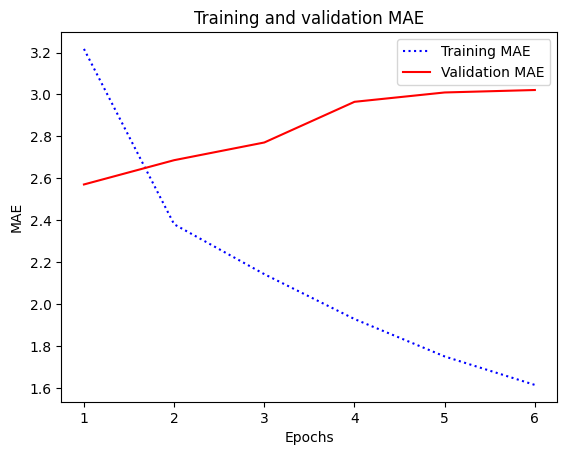

In [ ]:
loss = history_4.history["mae"]
val_loss = history_4.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_4 = keras.models.load_model("jena_conv1d_rnn.keras")
print(f"✅ Validation MAE: {model_4.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_4.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 24s 56ms/step - loss: 10.9386 - mae: 2.5706
✅ Validation MAE: 2.57
405/405 [==============================] - 23s 56ms/step - loss: 12.1726 - mae: 2.7511
✅ Test MAE: 2.75


### **Model 5 - Simple RNN - Stacking RNN layers**

In [ ]:
# Build the model
model_5 = keras.Sequential([
    layers.SimpleRNN(32, return_sequences=True, input_shape=(sequence_length, raw_data.shape[-1])),
    layers.SimpleRNN(32),
    layers.Dense(1)
])

# Compile
model_5.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_rnn.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

# Train
history_5 = model_5.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30
819/819 [==============================] - 133s 160ms/step - loss: 21.3057 - mae: 3.3197 - val_loss: 9.3187 - val_mae: 2.3843
Epoch 2/30
819/819 [==============================] - 111s 135ms/step - loss: 10.2368 - mae: 2.4948 - val_loss: 9.0384 - val_mae: 2.3393
Epoch 3/30
819/819 [==============================] - 113s 137ms/step - loss: 9.7192 - mae: 2.4285 - val_loss: 8.8294 - val_mae: 2.3090
Epoch 4/30
819/819 [==============================] - 130s 158ms/step - loss: 9.4053 - mae: 2.3885 - val_loss: 8.8265 - val_mae: 2.3130
Epoch 5/30
819/819 [==============================] - 113s 138ms/step - loss: 9.1319 - mae: 2.3563 - val_loss: 9.7421 - val_mae: 2.4271
Epoch 6/30
819/819 [==============================] - 113s 138ms/step - loss: 8.8519 - mae: 2.3206 - val_loss: 9.5489 - val_mae: 2.4005
Epoch 7/30
819/819 [==============================] - 113s 137ms/step - loss: 8.6705 - mae: 2.2956 - val_loss: 9.2231 - val_mae: 2.3611
Epoch 8/30
819/819 [==========================

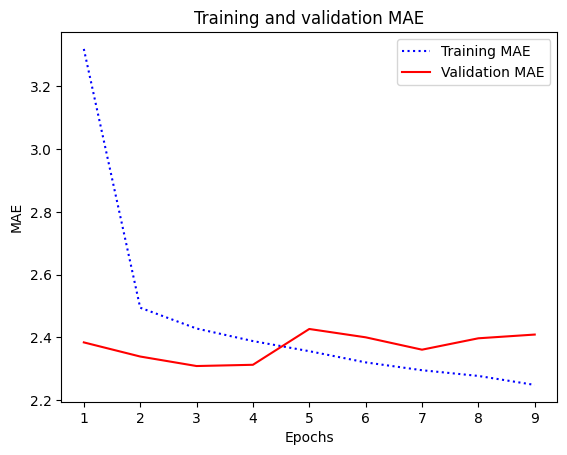

In [ ]:
loss = history_5.history["mae"]
val_loss = history_5.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_5 = keras.models.load_model("jena_stacked_rnn.keras")
print(f"✅ Validation MAE: {model_5.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_5.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 27s 64ms/step - loss: 8.8265 - mae: 2.3130
✅ Validation MAE: 2.31
405/405 [==============================] - 27s 66ms/step - loss: 10.0277 - mae: 2.4665
✅ Test MAE: 2.47


### **Model 6 - Simple RNN - Stacking RNN layers with Dropout-regularized**

In [ ]:
model_6 = keras.Sequential([
    layers.SimpleRNN(32, return_sequences=True, input_shape=(sequence_length, raw_data.shape[-1])),
    layers.Dropout(0.2),
    layers.SimpleRNN(32),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model_6.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_rnn_dropout.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# Train the model
history_6 = model_6.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
819/819 [==============================] - 138s 165ms/step - loss: 26.4517 - mae: 3.7606 - val_loss: 9.8981 - val_mae: 2.4110
Epoch 2/50
819/819 [==============================] - 133s 162ms/step - loss: 13.3733 - mae: 2.8665 - val_loss: 9.6909 - val_mae: 2.4024
Epoch 3/50
819/819 [==============================] - 132s 161ms/step - loss: 12.6873 - mae: 2.7941 - val_loss: 9.6513 - val_mae: 2.4131
Epoch 4/50
819/819 [==============================] - 133s 162ms/step - loss: 12.1271 - mae: 2.7336 - val_loss: 9.3997 - val_mae: 2.3669
Epoch 5/50
819/819 [==============================] - 131s 160ms/step - loss: 11.7650 - mae: 2.6876 - val_loss: 9.2702 - val_mae: 2.3596
Epoch 6/50
819/819 [==============================] - 133s 163ms/step - loss: 11.4545 - mae: 2.6524 - val_loss: 9.8067 - val_mae: 2.4371
Epoch 7/50
819/819 [==============================] - 132s 161ms/step - loss: 11.2525 - mae: 2.6268 - val_loss: 9.3536 - val_mae: 2.3766
Epoch 8/50
819/819 [=====================

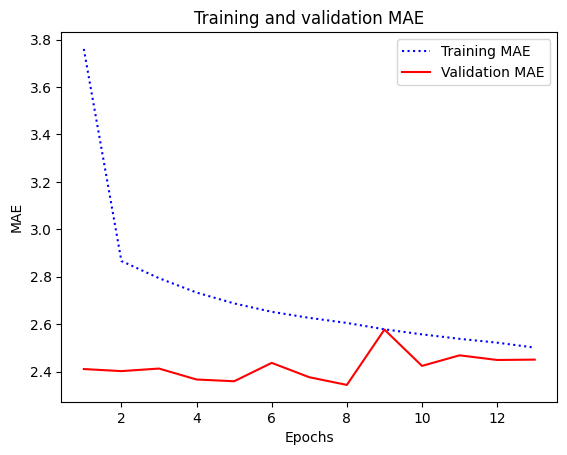

In [ ]:
loss = history_6.history["mae"]
val_loss = history_6.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_6 = keras.models.load_model("jena_rnn_dropout.keras")
print(f"✅ Validation MAE: {model_6.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_6.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 27s 64ms/step - loss: 9.1961 - mae: 2.3441
✅ Validation MAE: 2.34
405/405 [==============================] - 27s 67ms/step - loss: 10.4851 - mae: 2.5207
✅ Test MAE: 2.52


## **Model 7 - A Simple GRU**

In [ ]:
model_7 = keras.models.Sequential([
    layers.GRU(32),
    layers.Dense(1)
])

# Compile the model
model_7.compile(
    optimizer="rmsprop",
    loss="mse",
    metrics=["mae"]
)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru_simple.keras", save_best_only=True)
]

# Train the model
history_7 = model_7.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/20
819/819 [==============================] - 138s 164ms/step - loss: 21.6545 - mae: 3.3299 - val_loss: 9.6848 - val_mae: 2.3940
Epoch 2/20
819/819 [==============================] - 133s 162ms/step - loss: 9.4576 - mae: 2.3960 - val_loss: 9.8394 - val_mae: 2.3927
Epoch 3/20
819/819 [==============================] - 145s 177ms/step - loss: 8.8077 - mae: 2.3104 - val_loss: 10.6165 - val_mae: 2.4858
Epoch 4/20
819/819 [==============================] - 145s 177ms/step - loss: 8.3070 - mae: 2.2479 - val_loss: 9.9799 - val_mae: 2.4224
Epoch 5/20
819/819 [==============================] - 147s 179ms/step - loss: 7.8310 - mae: 2.1871 - val_loss: 10.1488 - val_mae: 2.4475
Epoch 6/20
819/819 [==============================] - 134s 164ms/step - loss: 7.3965 - mae: 2.1270 - val_loss: 10.2748 - val_mae: 2.4591
Epoch 7/20
819/819 [==============================] - 132s 161ms/step - loss: 7.0066 - mae: 2.0715 - val_loss: 9.9859 - val_mae: 2.4368
Epoch 8/20
819/819 [========================

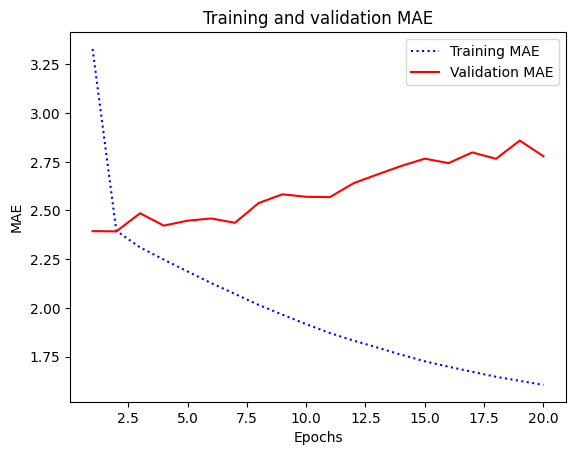

In [ ]:
loss = history_7.history["mae"]
val_loss = history_7.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_7 = keras.models.load_model("jena_gru_simple.keras")
print(f"✅ Validation MAE: {model_7.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_7.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 31s 71ms/step - loss: 9.6848 - mae: 2.3940
✅ Validation MAE: 2.39
405/405 [==============================] - 28s 68ms/step - loss: 10.4293 - mae: 2.5174
✅ Test MAE: 2.52


## **Model 8 - A Stacked GRU**

In [ ]:
model_8 = keras.Sequential([
    layers.GRU(32, return_sequences=True, dropout=0.2),
    layers.GRU(32, dropout=0.2),
    layers.Dense(1)
])

model_8.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("stacked_gru_dropout.keras", save_best_only=True)
]

history_8 = model_8.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/30
819/819 [==============================] - 257s 306ms/step - loss: 21.9333 - mae: 3.3728 - val_loss: 9.4337 - val_mae: 2.3773
Epoch 2/30
819/819 [==============================] - 248s 303ms/step - loss: 9.9223 - mae: 2.4684 - val_loss: 9.6796 - val_mae: 2.4059
Epoch 3/30
819/819 [==============================] - 248s 302ms/step - loss: 9.1078 - mae: 2.3640 - val_loss: 10.5720 - val_mae: 2.5193
Epoch 4/30
819/819 [==============================] - 246s 300ms/step - loss: 8.4190 - mae: 2.2766 - val_loss: 10.4371 - val_mae: 2.5212
Epoch 5/30
819/819 [==============================] - 248s 303ms/step - loss: 7.7408 - mae: 2.1857 - val_loss: 10.3055 - val_mae: 2.5033
Epoch 6/30
819/819 [==============================] - 289s 353ms/step - loss: 7.1031 - mae: 2.0969 - val_loss: 11.2761 - val_mae: 2.6165
Epoch 7/30
819/819 [==============================] - 247s 301ms/step - loss: 6.4969 - mae: 2.0072 - val_loss: 12.2586 - val_mae: 2.7241
Epoch 8/30
819/819 [======================

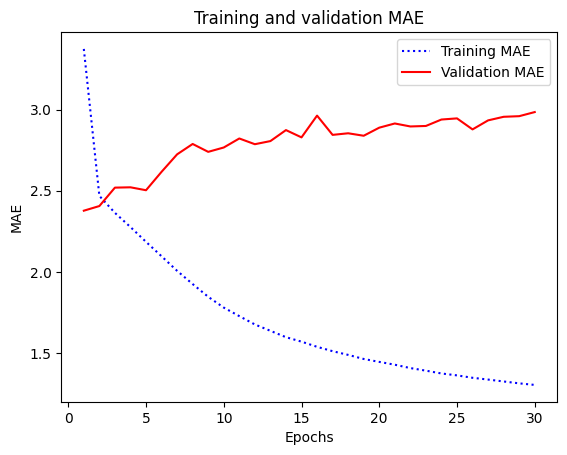

In [ ]:
loss = history_8.history["mae"]
val_loss = history_8.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_8 = keras.models.load_model("stacked_gru_dropout.keras")
print(f"✅ Validation MAE: {model_8.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_8.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 42s 100ms/step - loss: 9.4337 - mae: 2.3773
✅ Validation MAE: 2.38
405/405 [==============================] - 41s 101ms/step - loss: 10.5874 - mae: 2.5367
✅ Test MAE: 2.54


## **LSTM(Long Short-Term Memory )**

# **Model 9 - LSTM-Simple**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model_9 = keras.Sequential([
    layers.Input(shape=(sequence_length, raw_data.shape[-1])),
    layers.LSTM(32),
    layers.Dense(1)
])

model_9.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

history_9 = model_9.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 135s 161ms/step - loss: 23.0034 - mae: 3.4404 - val_loss: 9.9352 - val_mae: 2.4481
Epoch 2/10
819/819 [==============================] - 131s 160ms/step - loss: 9.3456 - mae: 2.3877 - val_loss: 9.7972 - val_mae: 2.4277
Epoch 3/10
819/819 [==============================] - 134s 164ms/step - loss: 8.4109 - mae: 2.2657 - val_loss: 9.8811 - val_mae: 2.4350
Epoch 4/10
819/819 [==============================] - 133s 163ms/step - loss: 7.8160 - mae: 2.1846 - val_loss: 10.1644 - val_mae: 2.4723
Epoch 5/10
819/819 [==============================] - 132s 161ms/step - loss: 7.2483 - mae: 2.1054 - val_loss: 10.0749 - val_mae: 2.4781
Epoch 6/10
819/819 [==============================] - 134s 163ms/step - loss: 6.8635 - mae: 2.0461 - val_loss: 10.8889 - val_mae: 2.5556
Epoch 7/10
819/819 [==============================] - 133s 162ms/step - loss: 6.5089 - mae: 1.9904 - val_loss: 10.5787 - val_mae: 2.5242
Epoch 8/10
819/819 [=======================

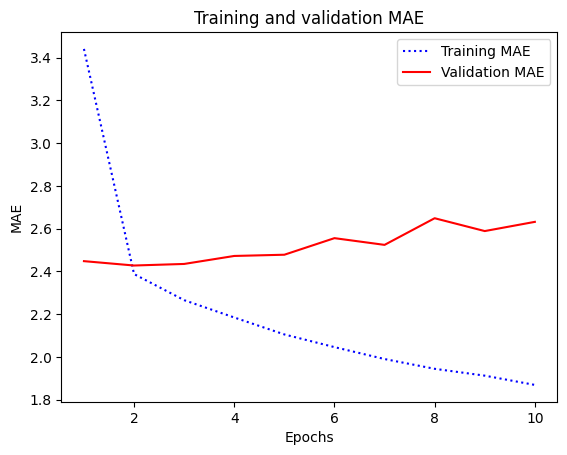

In [ ]:
loss = history_9.history["mae"]
val_loss = history_9.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_9 = keras.models.load_model("jena_lstm.keras")
print(f"✅ Validation MAE: {model_9.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_9.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 29s 70ms/step - loss: 9.7972 - mae: 2.4277
✅ Validation MAE: 2.43
405/405 [==============================] - 31s 75ms/step - loss: 10.8861 - mae: 2.5863
✅ Test MAE: 2.59


# **Model 10 - LSTM + Dropout Regularization**

In [ ]:
model_10 = keras.Sequential([
    layers.Input(shape=(sequence_length, raw_data.shape[-1])),
    layers.LSTM(32, dropout=0.2),
    layers.Dense(1)
])

model_10.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [keras.callbacks.ModelCheckpoint("lstm_dropout.keras", save_best_only=True)]

history_10 = model_10.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 151s 181ms/step - loss: 22.1628 - mae: 3.4097 - val_loss: 10.3324 - val_mae: 2.5059
Epoch 2/10
819/819 [==============================] - 146s 178ms/step - loss: 10.2292 - mae: 2.4985 - val_loss: 9.7958 - val_mae: 2.4432
Epoch 3/10
819/819 [==============================] - 146s 178ms/step - loss: 9.4721 - mae: 2.4006 - val_loss: 9.6497 - val_mae: 2.4115
Epoch 4/10
819/819 [==============================] - 143s 174ms/step - loss: 8.8781 - mae: 2.3262 - val_loss: 10.1329 - val_mae: 2.4756
Epoch 5/10
819/819 [==============================] - 148s 181ms/step - loss: 8.3634 - mae: 2.2570 - val_loss: 10.3351 - val_mae: 2.5110
Epoch 6/10
819/819 [==============================] - 144s 176ms/step - loss: 7.9179 - mae: 2.1945 - val_loss: 10.7646 - val_mae: 2.5692
Epoch 7/10
819/819 [==============================] - 146s 178ms/step - loss: 7.4972 - mae: 2.1351 - val_loss: 11.2183 - val_mae: 2.6365
Epoch 8/10
819/819 [=====================

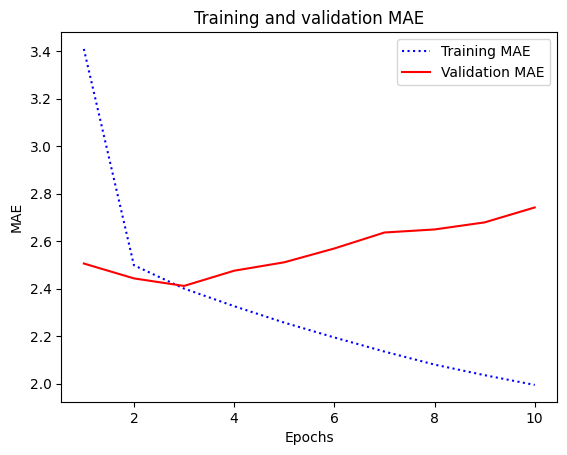

In [ ]:
loss = history_10.history["mae"]
val_loss = history_10.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_10 = keras.models.load_model("lstm_dropout.keras")
print(f"✅ Validation MAE: {model_10.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_10.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 34s 82ms/step - loss: 9.6497 - mae: 2.4115
✅ Validation MAE: 2.41
405/405 [==============================] - 32s 78ms/step - loss: 10.4509 - mae: 2.5569
✅ Test MAE: 2.56


# **Model 11 - Bidirectional LSTM model**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model_11 = keras.Sequential([
    layers.Input(shape=(sequence_length, raw_data.shape[-1])),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(1)
])

# Compile the model
model_11.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Set up callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("bilstm.keras", save_best_only=True)
]

# Train the model
history_11 = model_11.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 211s 252ms/step - loss: 16.5838 - mae: 2.9730 - val_loss: 9.8654 - val_mae: 2.4255
Epoch 2/10
819/819 [==============================] - 206s 251ms/step - loss: 8.1236 - mae: 2.2129 - val_loss: 10.2712 - val_mae: 2.4717
Epoch 3/10
819/819 [==============================] - 205s 249ms/step - loss: 6.9761 - mae: 2.0505 - val_loss: 10.7788 - val_mae: 2.5373
Epoch 4/10
819/819 [==============================] - 207s 252ms/step - loss: 6.1842 - mae: 1.9337 - val_loss: 11.9621 - val_mae: 2.6603
Epoch 5/10
819/819 [==============================] - 206s 251ms/step - loss: 5.5214 - mae: 1.8278 - val_loss: 12.5605 - val_mae: 2.7304
Epoch 6/10
819/819 [==============================] - 208s 253ms/step - loss: 5.0321 - mae: 1.7451 - val_loss: 12.8136 - val_mae: 2.7571
Epoch 7/10
819/819 [==============================] - 207s 252ms/step - loss: 4.5879 - mae: 1.6680 - val_loss: 12.4918 - val_mae: 2.7383
Epoch 8/10
819/819 [=====================

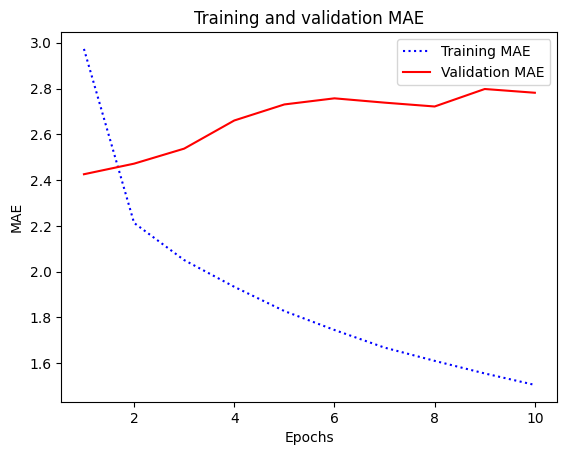

In [ ]:
loss = history_11.history["mae"]
val_loss = history_11.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
# Load best model and evaluate
model_11 = keras.models.load_model("bilstm.keras")
print(f"✅ Validation MAE: {model_11.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_11.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 42s 100ms/step - loss: 9.8654 - mae: 2.4255
✅ Validation MAE: 2.43
405/405 [==============================] - 44s 106ms/step - loss: 10.7857 - mae: 2.5893
✅ Test MAE: 2.59


# **Model 12 - Conv1D + LSTM Hybrid Model**

In [ ]:
model_12 = keras.Sequential([
    layers.Input(shape=(sequence_length, raw_data.shape[-1])),
    layers.Conv1D(32, kernel_size=5, activation="relu"),
    layers.MaxPooling1D(pool_size=2),
    layers.LSTM(32),
    layers.Dense(1)
])

model_12.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("conv1d_lstm.keras", save_best_only=True)
]

history_12 = model_12.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/10
819/819 [==============================] - 128s 152ms/step - loss: 21.6262 - mae: 3.3093 - val_loss: 9.4005 - val_mae: 2.3713
Epoch 2/10
819/819 [==============================] - 124s 151ms/step - loss: 7.7532 - mae: 2.1658 - val_loss: 11.1914 - val_mae: 2.6158
Epoch 3/10
819/819 [==============================] - 121s 148ms/step - loss: 6.3672 - mae: 1.9534 - val_loss: 11.9043 - val_mae: 2.7045
Epoch 4/10
819/819 [==============================] - 119s 145ms/step - loss: 5.4322 - mae: 1.7988 - val_loss: 13.0634 - val_mae: 2.7903
Epoch 5/10
819/819 [==============================] - 122s 148ms/step - loss: 4.7911 - mae: 1.6890 - val_loss: 12.7530 - val_mae: 2.7969
Epoch 6/10
819/819 [==============================] - 122s 149ms/step - loss: 4.3282 - mae: 1.6020 - val_loss: 13.3154 - val_mae: 2.8675
Epoch 7/10
819/819 [==============================] - 121s 147ms/step - loss: 3.9749 - mae: 1.5311 - val_loss: 13.8899 - val_mae: 2.8986
Epoch 8/10
819/819 [=====================

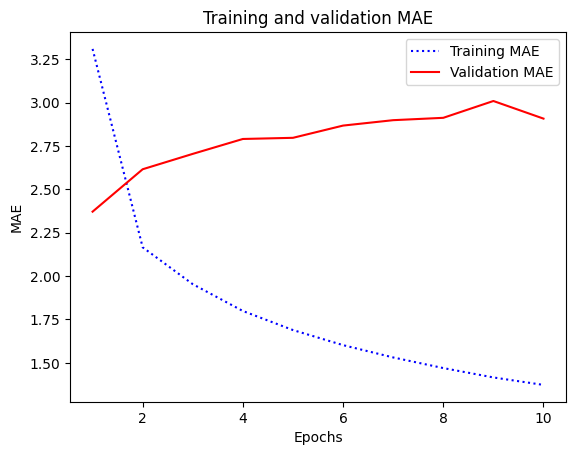

In [ ]:
loss = history_12.history["mae"]
val_loss = history_12.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="blue", linestyle="dotted", label="Training MAE")
plt.plot(epochs,  val_loss, color="red",linestyle="solid", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [ ]:
model_12 = keras.models.load_model("conv1d_lstm.keras")
print(f"✅ Validation MAE: {model_12.evaluate(val_dataset)[1]:.2f}")
print(f"✅ Test MAE: {model_12.evaluate(test_dataset)[1]:.2f}")

408/408 [==============================] - 27s 63ms/step - loss: 9.4005 - mae: 2.3713
✅ Validation MAE: 2.37
405/405 [==============================] - 27s 66ms/step - loss: 11.0386 - mae: 2.6065
✅ Test MAE: 2.61


# **Conclusion**

In [ ]:
import pandas as pd

# Define the table data for your 12 models
data = {
    "Model": [
        "Model 1", "Model 2", "Model 3", "Model 4", "Model 5", "Model 6",
        "Model 7", "Model 8", "Model 9", "Model 10", "Model 11", "Model 12"
    ],
    "Architecture": [
        "Baseline (No ML)", "Dense Layer", "Simple RNN", "1D Conv", "Stacked RNN",
        "Stacked RNN + Dropout", "GRU", "Stacked GRU", "Simple LSTM", "LSTM + Dropout",
        "Bidirectional LSTM", "Conv1D + LSTM"
    ],
    "Dropout": [
        "No", "No", "No", "No", "No", "Yes (0.2)", "No", "No", "No", "Yes (0.2)",
        "No", "No"
    ],
    "Validation MAE": [
        2.44, 2.52, 2.32, 2.57, 2.34, 2.34, 2.39, 2.38, 2.43, 2.41, 2.43, 2.37
    ],
    "Test MAE": [
        2.62, 2.67, 2.45, 2.75, 2.49, 2.52, 2.52, 2.54, 2.59, 2.56, 2.59, 2.61
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Display the table
from IPython.display import display
display(df)

,Model,Architecture,Dropout,Validation MAE,Test MAE
0,Model 1,Baseline (No ML),No,2.44,2.62
1,Model 2,Dense Layer,No,2.52,2.67
2,Model 3,Simple RNN,No,2.32,2.45
3,Model 4,1D Conv,No,2.57,2.75
4,Model 5,Stacked RNN,No,2.34,2.49
5,Model 6,Stacked RNN + Dropout,Yes (0.2),2.34,2.52
6,Model 7,GRU,No,2.39,2.52
7,Model 8,Stacked GRU,No,2.38,2.54
8,Model 9,Simple LSTM,No,2.43,2.59
9,Model 10,LSTM + Dropout,Yes (0.2),2.41,2.56


# **Comparing all models using graph**

Model 1 - Baseline No ML
Model 2 - A basic machine-learning model-Dense Layer  
Model 3 - A simple RNN      
Model 4 - 1D Convolutional model     
Model 5 - Simple RNN-Stacking RNN Layers   
Model 6 - Simple RNN-Stacking RNN Layers with Dropout regularized  
Model 7 - A Simple GRU  
Model 8 - A Stacked GRU (2 Layers)  
Model 9 - LSTM-Simple    
Model 10 - LSTM+Dropout Regularization
Model 11 - Bidirectional LSTM  
Model 12 - Conv1D+LSTM hybrid Model

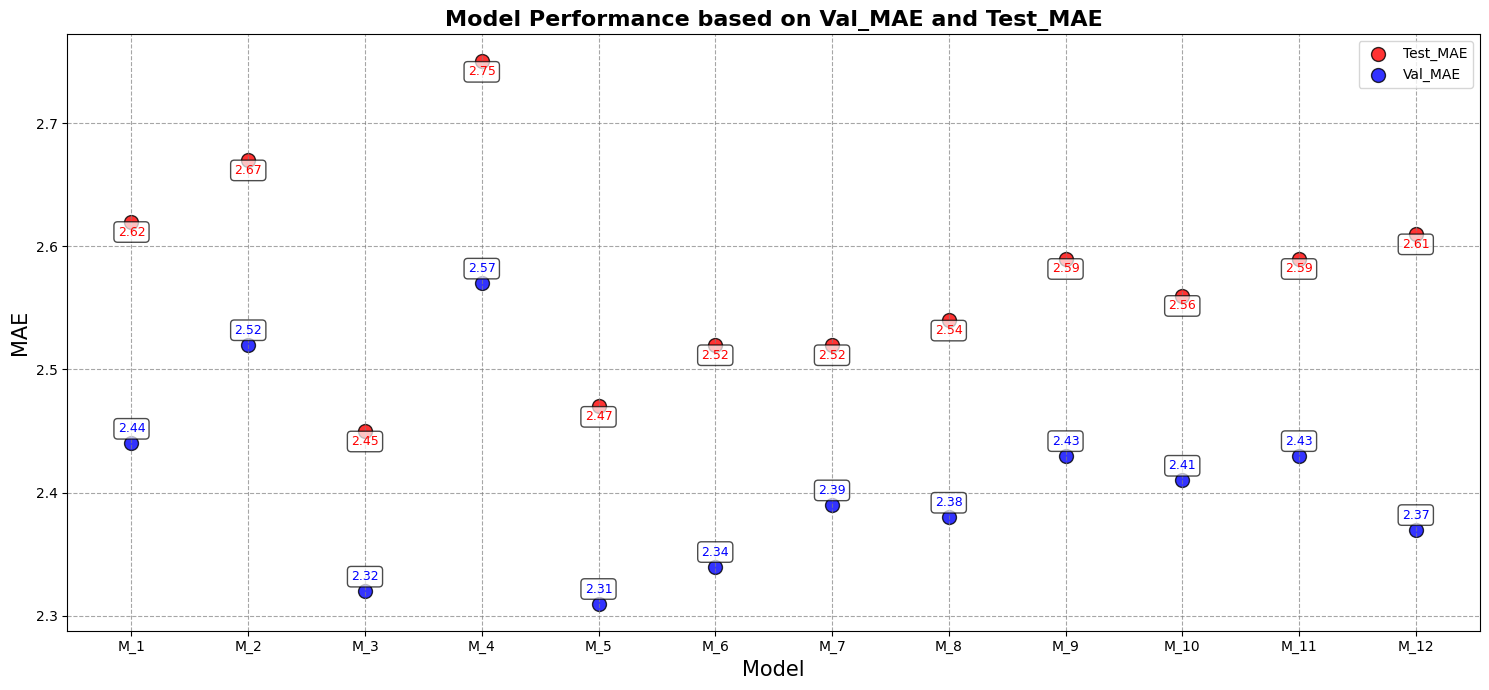

In [ ]:
 import numpy as np
 import pandas as pd
 import matplotlib.pyplot as plt
 # Define labels, Val_MAE, and Test_MAE values
 Labels = [
    'M_1', 'M_2', 'M_3', 'M_4', 'M_5', 'M_6', 'M_7', 'M_8', 'M_9', 'M_10',
    'M_11', 'M_12'
 ]
 Val_MAE = [
    2.44, 2.52, 2.32, 2.57, 2.31, 2.34, 2.39, 2.38, 2.43, 2.41, 2.43, 2.37
 ]
 Test_MAE = [
    2.62, 2.67, 2.45, 2.75, 2.47, 2.52, 2.52, 2.54, 2.59, 2.56, 2.59, 2.61
 ]
 # Creating a figure with a specified size
 plt.figure(figsize=(15, 7))
 # Scatter plot to visualize Val_MAE for different models
 plt.scatter(Labels, Val_MAE, color='blue', s=100, edgecolor='black', alpha=0.8, label='Val_MAE')
 # Scatter plot to visualize Test_MAE for different models
 plt.scatter(Labels, Test_MAE, color='red', s=100, edgecolor='black', alpha=0.8, label='Test_MAE')
 # Adding annotations for Val_MAE
 for i, txt in enumerate(Val_MAE):
    plt.annotate(f"{txt}", (Labels[i], Val_MAE[i]), fontsize=9, ha='center',
                 xytext=(0, 8), textcoords='offset points', color='blue',
                 bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))
 # Adding annotations for Test_MAE
 for i, txt in enumerate(Test_MAE):
    plt.annotate(f"{txt}", (Labels[i], Test_MAE[i]), fontsize=9, ha='center',
                 xytext=(0, -10), textcoords='offset points', color='red',
                 bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))
 # Adding title and labels
 plt.title("Model Performance based on Val_MAE and Test_MAE", fontsize=16, fontweight='bold')
 plt.xlabel("Model", fontsize=15)
 plt.ylabel("MAE", fontsize=15)
 # Displaying grid with specific color and style
 plt.grid(color='gray', linestyle='--', alpha=0.7)
 # Adding legend to distinguish Val_MAE and Test_MAE
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[1], handles[0]], ['Test_MAE', 'Val_MAE'], loc='upper right')
 # Adjust layout to avoid overlap
 plt.tight_layout()
 # Show plot
 plt.show()